# Explainer notebook

The explainer notebook includes all details of our project. Thus, introduction to the datasets, the conducted data-analysis of the project and additionally, explanations of methodology, visualizations, etc. can be found in the notebook. 

## 0. Setting up the notebook

Import of nessasary packages to run the notebook.

In [ ]:
# Installing packages
!pip install openpyxl
!pip install rtree
!pip install graphviz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import time
import seaborn as sns
from shapely.geometry import Point
import geopandas
from shapely import wkt
import matplotlib.dates as md
import json
import requests
import geopandas as gpd
from folium.plugins import HeatMap, HeatMapWithTime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

import graphviz
from sklearn import tree
from IPython.display import Image

from bokeh.models import ColumnDataSource, Legend, HoverTool, FactorRange
from bokeh.plotting import figure, output_file, show, save
from bokeh.io import output_notebook, curdoc
from bokeh.layouts import layout, column, row, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.transform import dodge

import tempfile
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

sns.set()
pal = sns.color_palette()
colors = pal.as_hex()

def plot_bokeh(plot):
    output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    output_file(output_filename)
    save(plot)

    f = open(output_filename, "r")
    display(HTML(f.read()))

## 1. Motivation

* What is your dataset?
>For this project, we have chosen to work with 2 different datasets. 
>Our initial dataset consists of traffic data taken from [opendata.dk](https://www.opendata.dk/city-of-copenhagen/trafiktal). The dataset focuses upon vehicles (cars, scootes, trucks, bicycles, electrical scooters etc.) as well as pedestrians. It consists of manual traffic countings for different spots in the city of Copenhagen along with the geographical locations of those spots. However, as the dataset was already preprocessed and did not consist of the specific timestamps for which countings were conducted, we contacted the owner of the dataset - the counting coordinator Åse Boss Henrichsen from the Copenhagen Municipality (Københavns Teknik- og Miljøforvaltning). This provided us with the raw dataset with timestamps along with a traffic counting guide about how they were obtained (`traffic_counting_in_cph.pdf`) [1]. To limit our research, we have focused on data taken 2009 to 2018.

>For our predictive analysis, we have obtained data from [DMI](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616) using an API-call. Here, we have extracted the wind speed, precipitation and temperature per hour according to the dates, where countings have been registered in the traffic dataset.

* Why did you choose this/these particular dataset(s)?
>During recent years, there has been an increased focus on climate change and employing greener incentives for Copenhagen. Thus, the data has been chosen as it allows us to look into the use of different modes of transportation, specifically to track both cars and bikes along with conducting analysis and comparisons of their patterns. 

* What was your goal for the end user's experience?
>The primary goal for the project is to visualize and educate the reader in regards to trends for bikes and cars in Copenhagen. We want to encapsulate the reader using relaxing colors and interactive plots with tools such as Bokeh and Folium, while combining it with an *easy to read* website in a linear format. This gives the reader the possibility for educating themselves, forming their own opinions, guided by us, in an intuitive reading manner.

## 2. Basic stats. Let's understand the dataset better

### 2.1 Merge of the preprocessed dataset and the original dataset

As written in the description about our dataset, there are key differences between the preprocessed dataset and the original (raw) dataset. The preprocessed dataset consists of geographical locations of where each counting have taken place, while the original dataset consists of the number of measurements on an hourly basis. Both aspects are important to keep, so we start by merging the datasets. But first, we have to load the two datasets:

In [ ]:
# Loading the datasets
df_tt = pd.read_csv('data/trafiktaelling.csv').drop(columns='FID')

df_traffic = pd.read_excel('data/SQL_2019.xlsx',
                            parse_dates= {"date" : ["ÅR","DATO"]})

# Transform our column to date object
df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y %m%d')

# Look at the 2009-2018 time window
df_traffic = df_traffic[df_traffic.date.dt.year > 2008]

The original dataset, `df_tt` has a column `t_nr`, which acts as an ID for the location of the measurement. It is thus directly linked to the geolocation, which is stored in the `wkb_geometry` column. We can thus create a mapping from `t_nr` to `wkb_geometry`, i.e. we only need those two columns. We find also any duplicate values in terms of `t_nr`.

In [ ]:
# Extract the relevant columns for mapping
df_tt_mapping = df_tt[['t_nr', 'wkb_geometry']]

# Inspect duplicate value of t_nr
t_nr_mult = df_tt_mapping.groupby('t_nr').size()
df_tt_mapping[df_tt_mapping.t_nr.isin(t_nr_mult[t_nr_mult > 1].keys())]

t_nr                                   wkb_geometry
151   478  POINT (12.564051414660698 55.706747764334814)
152   478  POINT (12.564051414660698 55.706747764334814)
182   602   POINT (12.558283833286113 55.67068892477301)
183   602   POINT (12.558283833286113 55.67068892477301)
295   775   POINT (12.55221192858649 55.697888963995155)
296   775  POINT (12.551928783743692 55.697898379062565)
427   938  POINT (12.531054185830063 55.702777372497984)
428   938  POINT (12.531054185830063 55.702777372497984)
625  7630    POINT (12.5775112256451 55.715633565490066)
626  7630    POINT (12.5775112256451 55.715633565490066)
716  9703   POINT (12.583662808767516 55.72009422647465)
717  9703   POINT (12.583662808767516 55.72009422647465)
718  9703   POINT (12.583662808767516 55.72009422647465)
751  9780   POINT (12.541106534414164 55.70465915279287)
752  9780   POINT (12.541106534414164 55.70465915279287)
821  9884                                            NaN
822  9884  POINT (12.540045341874835 55.707998921690134)
862  9930   POINT (12.591272415702276 55.67958309549209)
863  9930   POINT (12.591272415702276 55.67958309549209)

Here, it is clearly seen that each time `t_nr` is duplicated, `wkb_geometry` is also duplicated. Thus there is indeed a direct mapping between `t_nr` and `wkb_geometry`. We also see that for `t_nr=9884`, one of the point takes a `NaN` value. Since all other (`t_nr`, `wkb_geometry`) pairs match, we assume that it is an error in the dataset and proceed by using the same location as the other value with `t_nr=9884`. This allows for making a dictionary of the (`t_nr`, `wkb_geometry`) mapping.

The raw dataset `df_traffic` has the column `TS`, which is directly the same as the values in `t_nr`, thus `TS` is used for obtaining the coordinates.

Also, we inspect the `NaN` values in the `wkb_geometry` column:

In [ ]:
# Map the datapoints
d_mapping = df_tt_mapping.drop_duplicates(subset='t_nr', keep='last').set_index('t_nr')['wkb_geometry'].to_dict()
df_traffic['wkb_geometry'] = df_traffic['TS'].map(d_mapping)

# Print where location is NAN
df_traffic[df_traffic['wkb_geometry'].isna()].VEJNAVN.unique()

array(['VASBYGADE 40 v.f. Vestre Teglgade',
       'SKELBÆKGADE 30 nordvest for Kødboderne',
       'DRONNINGENSGADE 48 - ensrettet mod nordøst', 'LINNÉSGADE 12'],
      dtype=object)

After an inspection using Google Maps, we have found that none of these places are actually close to each other. Thus we make the choice of dropping the entries where `wkb_geometry` is `NaN` and look for other `NaN` values in our dataset in other columns.

In [ ]:
# Drop nans
df_traffic.dropna(subset=['wkb_geometry'], inplace=True)

# Inspect null values
df_traffic.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31950 entries, 19610 to 148814
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          31950 non-null  datetime64[ns]
 1   TS            31950 non-null  int64         
 2   VEJNAVN       31950 non-null  object        
 3   RETNING       31849 non-null  object        
 4   KATEGORI      31950 non-null  object        
 5   ANTAL 6-7     34 non-null     float64       
 6   ANTAL 7-8     31950 non-null  float64       
 7   ANTAL 8-9     31950 non-null  float64       
 8   ANTAL 9-10    31950 non-null  float64       
 9   ANTAL 10-11   31950 non-null  float64       
 10  ANTAL 11-12   31950 non-null  float64       
 11  ANTAL 12-13   31950 non-null  float64       
 12  ANTAL 13-14   31950 non-null  float64       
 13  ANTAL 14-15   31950 non-null  float64       
 14  ANTAL 15-16   31950 non-null  float64       
 15  ANTAL 16-17   31950 non-null  f

It is seen that most of these values are in `ANTAL 6-7`, i.e. the number of samples between 6 and 7 in the morning. From [1], we know that the Copenhagen Municipality has switched their countings so that they counted from 7 to 19, instead of from 6 to 18. We thus keep the entries where the countings happened from 7 to 19:

In [ ]:
# Keep those where 6-7 were not measured
df_traffic = df_traffic[df_traffic['ANTAL 6-7'].isna()]

Going back to the geometry data, we split the column so that we get the longitude and the latitude:

In [ ]:
# Convert into geometry objects
df_traffic['wkb_geometry'] = geopandas.GeoSeries.from_wkt(df_traffic['wkb_geometry'])

# Extract lon and lat for plotting
df_traffic['lon'] = df_traffic.wkb_geometry.apply(lambda p: p.x)
df_traffic['lat'] = df_traffic.wkb_geometry.apply(lambda p: p.y)

Now, let us limit our dataset to only have cars and bikes, and select those columns that we want to work with. In our dataset, bicycles are counted with scooters, but from [1], we know that scooters only contribute to approximately 1% of the number. Thus, we regard the category as bikes only.

In [ ]:
# Select only cars and bikes
df = df_traffic[(df_traffic['KATEGORI'].str.lower() == 'personbiler') | (df_traffic['KATEGORI'].str.lower() == 'cykler + knallerter')]

# Select relevant columns
df = df[['TS', 'date', 'KATEGORI', 'lon', 'lat', 'ANTAL 7-8', 'ANTAL 8-9', 
                                       'ANTAL 9-10', 'ANTAL 10-11', 'ANTAL 11-12', 'ANTAL 12-13', 
                                       'ANTAL 13-14', 'ANTAL 14-15', 'ANTAL 15-16', 'ANTAL 16-17',
                                       'ANTAL 17-18', 'ANTAL 18-19']].reset_index(drop=True)

# Translate remaining columns to English
df.rename(columns={
    "TS": "id", 
    "KATEGORI": "category",
    "ANTAL 7-8": "7-8",
    'ANTAL 8-9': '8-9',
    'ANTAL 9-10': '9-10',
    'ANTAL 10-11': '10-11', 
    'ANTAL 11-12': '11-12', 
    'ANTAL 12-13': '12-13', 
    'ANTAL 13-14': '13-14', 
    'ANTAL 14-15': '14-15', 
    'ANTAL 15-16': '15-16', 
    'ANTAL 16-17': '16-17',
    'ANTAL 17-18': '17-18', 
    'ANTAL 18-19': '18-19'
    }, inplace=True)

# Translating cars and bikes from Danish to English
cb_mapper = {'PERSONBILER': 'cars', 'CYKLER + KNALLERTER': 'bikes'}
df['category'] = df.category.map(cb_mapper)

# Sum the observations of an entire day
df['entire_day'] = df[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum(axis=1)

Now that we have a cleaned dataset, we continue with our exploratory analysis.

### 2.2 Initial exploratory analysis

We start by exploring the development in terms of bikes and cars throughout the years:

In [ ]:
# Create year column
df['year'] = df.date.dt.year

# Select modes of transport
modes_of_transport=['bikes', 'cars']

# Sum up the number of observations for each year and category
df_temp = df.groupby(['year', 'category']).sum('entire_day').reset_index()
df_year_count = pd.pivot_table(df_temp, index='year', columns=['category'], values='entire_day')
df_year_count = df_year_count.reset_index()
df_year_count['year'] = df_year_count['year'].astype(str)

# Calculate fractions for bikes and cars
df_year_count['frac_bikes'] = df_year_count['bikes']/df_year_count[['cars', 'bikes']].sum(axis=1)*100
df_year_count['frac_cars'] = df_year_count['cars']/df_year_count[['cars', 'bikes']].sum(axis=1)*100

# Find number of counters each year
df_year_count['counters'] = df.groupby('year').count()['id'].values

# Make into ColumnDataSource
cds_year = ColumnDataSource(df_year_count)

Creating our visualization using Bokeh:

In [ ]:
# Create a list of years for plotting
years = list(df_year_count.reset_index()['year'].astype(str))

# Create the figure
p1 = figure(title='Number of observations for each mode of transport by year', 
            width=800, height=400, x_range=FactorRange(factors=years), y_range=[0,2000000])

p1.add_layout(Legend(), 'right')

# Adding vertical bars
p1.vbar_stack(['bikes', 'cars'], x='year', source=cds_year,
              width=.5, color=[colors[0], colors[1]], legend_label=['Bikes', 'Cars'])

p1.add_tools(HoverTool(tooltips=[("Fraction of bikes", "@frac_bikes%"),
                                 ('Fraction of cars', "@frac_cars%"),
                                 ('Total counters', '@counters')]))

# Formatters for plot
p1.yaxis.formatter.use_scientific = False
p1.xaxis.axis_label = 'Year'
p1.yaxis.axis_label = 'Number of observations'
p1.xgrid.grid_line_color = None
p1.background_fill_color = None
p1.border_fill_color = None
p1.outline_line_width = 0
p1.legend.border_line_width = 0
p1.legend.background_fill_color = None

plot_bokeh(p1)

We see that the number of observations taken for each mode of transport is approximately the same for each year, with a dip in 2017. Since we are dealing with count data, it is important to be careful not to strive to conclusions when it comes to this observation. It could be the case that the number of *counters*, i.e. people who had counted the number of bikes and cars at various locations, were less. Thus, we have added a tooltip that shows the number of total counters there had been the respective year.

From here we observe that there was indeed less counters, than the rest of the years. However, the drop does still appear to be more extreme. Comparing similar differences in counters, we see e.g. a difference of 60 counters from 2014-2015 and likewise for 2015-2017. However, the overall drop in observations is way bigger for 2015-2017 than 2014-2015. Thus, indicating that other external factors have influenced the drop besides the reduced number of counters.

Our other tooltip, showing the ratio between the number of bikes and cars for the respective year, shows quite stable levels for all years, but with cars being the dominant group.

In an ideal world, we would automatically capture the number of cars and bikes all 365 days of the year at the same locations each time. However, we have noticed different behaviour in 2017 and thus, we will inspect this year further, by observing the number of spots that have been counted on each day.

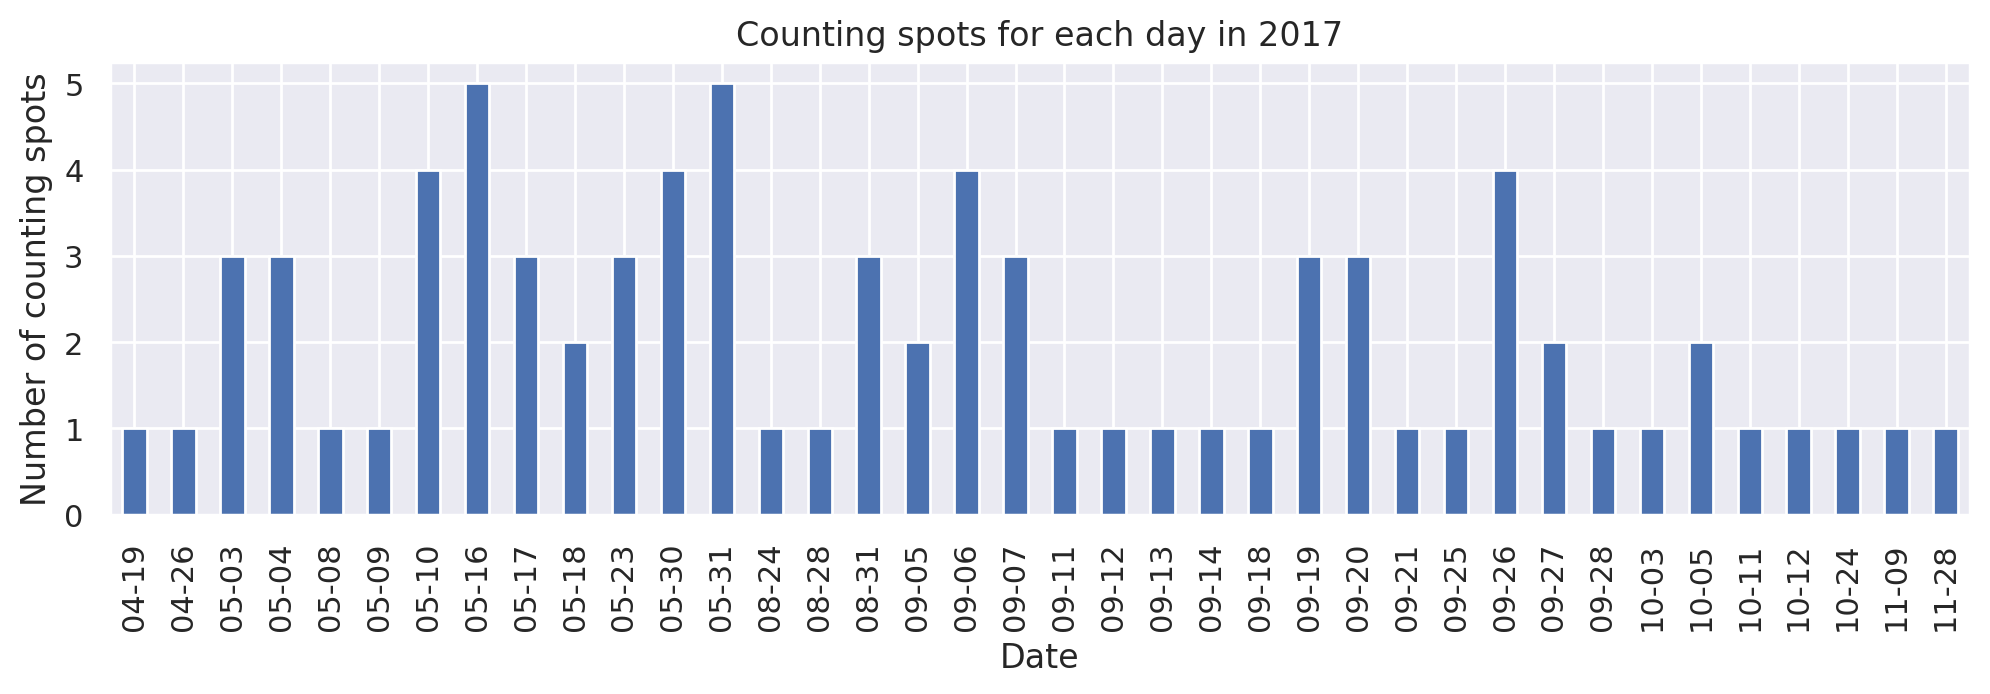

In [ ]:
# Extract values from 2017
df_2017_measurements = df[df.year == 2017].groupby(['date']).id.nunique()

# Plot our figure
fig, ax = plt.subplots(figsize=(12,3), dpi=200)
df_2017_measurements.plot(kind='bar',
                          ax=ax,
                          xlabel='Date',
                          ylabel='Number of counting spots',
                          title='Counting spots for each day in 2017')
ax.set_xticklabels([x.strftime("%m-%d") for x in df_2017_measurements.index])
plt.show()

As we see, there is also a lot of variation in terms of how many spots that are counted each day. Some days, there has only been one measurement spot, where during other days, multiple locations have been counted. This causes problems, since the more spots you count, the more observations you will get.

It also seems that during the Spring and Fall months, more measurements have been taken. We plot the total observations, i.e. the sum of observations for each month throughout our time period:

In [ ]:
# Find number of observations for each month and each category
df['month'] = df['date'].dt.month
df_temp = df.groupby(['month', 'category']).sum('entire_day').reset_index()
df_month_count = pd.pivot_table(df_temp, index='month', columns=['category'], values='entire_day')

# Add number of counters for each month
df_month_count['count'] = df.groupby('month').id.count()
df_month_count.reset_index(inplace=True)

# Map to get proper month names
month_mapper = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df_month_count['month'] = df_month_count['month'].map(month_mapper)

# Transform into CDS
cds_month = ColumnDataSource(df_month_count)

In [ ]:
# Plotting
p2 = figure(title='Number of observations for each mode of transport by month', 
            width=800, height=400, x_range=FactorRange(factors=list(month_mapper.values())), 
            y_range=[0, 7000000])

p2.add_layout(Legend(), 'right')

# Adding vertical bars
p2.vbar_stack(['bikes', 'cars'], x='month', source=cds_month,
              width=.5, color=[colors[0], colors[1]], legend_label=['Bikes', 'Cars'])

p2.add_tools(HoverTool(tooltips=[("Total counters", "@count")]))

# Formatter tools
p2.yaxis.formatter.use_scientific = False
p2.xaxis.major_label_orientation = "vertical"
p2.xaxis.axis_label = 'Month'
p2.yaxis.axis_label = 'Number of observations'
p2.xgrid.grid_line_color = None
p2.background_fill_color = None
p2.border_fill_color = None
p2.outline_line_width = 0
p2.legend.border_line_width = 0
p2.legend.background_fill_color = None

plot_bokeh(p2)

It becomes very apparent that the countings throughout the entire dataset had mainly taken place in April-June and September-October. In accordance to [1], the municipality conducts countings in May, June, August, September and October as part of their rotation program. Here, all districts are measured to ensure that we get a picture of the traffic in the entire city. However, it is seen that there are many measurement in April. This could be part of the municipality's *Other measurements*, which are provided for institutions such as Aarhus University and Vejdirektoratet. 

This could cause some inconsistency in where the countings take place also such as clustering for countings. Thus let us look at where the measurements have been taken:

In [ ]:
# plot a map of Copenhagen
map_hooray = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Plotting the points using folium's CircleMarker
# Loop over data, and include a couple extra information for each crime
for lng, lat in zip(df.lon, df.lat):
    folium.CircleMarker([lat, lng], radius=1.5,
                         fill=True,
                         ).add_to(map_hooray)

# Show the map
map_hooray

On the map, it is seen that the measurements have been taken all throughout Copenhagen. The largest clusters are found around central Copenhagen, Vesterbro and Nørrebro. Moving further out of the city center, it is seen that many measurements are taken around the main roads.

### 2.3 Conclusion on preliminary analysis
From our preliminary data analysis, we have seen that some issues are caused by inconsistency from when and where the measurements had been taken. For some years, there had been less counters, which directly influences the number of bikes and cars that had been counted. When plotting in terms of months, we saw that the observations were mainly taken in late Spring and early Autumn, which are popular months to bike in. The inconsistency means that for temporal patterns, it would make most sense to only look at the traffic activity throughout a day.

When it comes to the locations, measurements have been taken across the entire city. However, due to the rotation program, the locations for measurements each year are different. Therefore, we proceed by regarding the entire city as one.

## 3. Data Analysis

### 3.1 Temporal Patterns

In the following, we will look at temporal patterns on an hourly basis for each mode of transport from 7 to 19.

In [ ]:
# Seperate dataframe into cars and bikes
df_cars = df[df.category == 'cars']
df_bikes = df[df.category == 'bikes']

# Create dataframe for each hour
df_traffic_hour = pd.DataFrame()
df_traffic_hour['cars'] = df_cars[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()
df_traffic_hour['bikes'] = df_bikes[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()

cds_hour = ColumnDataSource(df_traffic_hour)

In [ ]:
# years = list(df_year_count.reset_index()['year'].astype(str))
p3 = figure(title='Number of observations for each hour', 
            width=800, height=400, x_range=FactorRange(factors=list(df_traffic_hour.index)),
            y_range=[0,1500000])

p3.add_layout(Legend(), 'right')

# Add bars
p3.vbar(x=dodge('index', -0.15, range=p3.x_range), top='bikes', width=0.3, source=cds_hour,
        legend_label="Bikes", color=colors[0])

p3.vbar(x=dodge('index',  0.15, range=p3.x_range), top='cars', width=0.3, source=cds_hour, 
        legend_label="Cars", color=colors[1])

# Formatter settings
p3.yaxis.formatter.use_scientific = False
p3.xaxis.axis_label = 'Time'
p3.yaxis.axis_label = 'Number of observations'
p3.xgrid.grid_line_color = None
p3.background_fill_color = None
p3.border_fill_color = None
p3.outline_line_width = 0
p3.legend.border_line_width = 0
p3.legend.background_fill_color = None
p3.legend.click_policy="hide"

plot_bokeh(p3)

Most of the traffic is seen in the morning before 9 and in the afternoon, starting at around 15, reaching its peak at 16-17. This is also during the peak hours, where we get to work, school etc. and back home again.

We also observe that there is a difference in the bikes/cars ratio in the morning. From 7 to 8, the difference is larger than from 8 to 9. This could be due to how people with cars tend to have longer commutes than those with bikes, thus having to wake up and drive earlier, possibly also to avoid traffic. Meanwhile, people with bikes avoid these factors.

### 3.2 Spatial Patterns

Now that we have seen how the development is throughout the day in the entire city as a whole, we would also like to examine some of the spatial patterns and the development in activity in the specific neighbourhoods and roads. We start out by loading the districts as a geojson, for making a Choropleth on our map and to create our dataframe.

In [ ]:
# import copenhagen districts as json
with open('data/copenhagen_districts.geojson') as f:
    data = json.load(f)

# Import copenhagen districts (ref: https://giedriusk.carto.com/tables/copenhagen_districts/public)
districts = gpd.read_file('data/copenhagen_districts.geojson')[['name', 'geometry']]

# Create dataframe with geographical locations
df_geo = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

# Join with the districts
df_with_districts = gpd.sjoin(df_geo, districts, op='within')

# Sum the observations to find the total amount of observations for each district
district_info_temp = df_with_districts.groupby(['name', 'category']).sum()[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum(axis=1).reset_index()

district_info_temp = pd.pivot_table(district_info_temp, values=0, index='name', columns=['category']).reset_index()

# Add back districts
df_districts = district_info_temp.merge(districts)

# Add properties with number of cars and bikes to make tooltips for plotting
for i in range(len(data['features'])):
    name = data['features'][i]['properties']['name']
    data['features'][i]['properties']['Bikes'] = int(df_districts[df_districts.name == name]['bikes'].values[0])
    data['features'][i]['properties']['Cars'] = int(df_districts[df_districts.name == name]['cars'].values[0])
    data['features'][i]['properties']['District'] = str(name)

We plot the activity throughout the entire timeline of our plot, first for the bikes.

In [ ]:
# Plot heatmap with districts

Choropleth_bikes = folium.Choropleth(geo_data=data, data=df_districts, columns=['name', 'bikes'], key_on='feature.properties.name', fill_opacity=0, line_opacity=1, line_weight=2)

# Adding the data to the map
Choropleth_bikes.geojson.add_child(folium.features.GeoJsonTooltip(['District', 'Bikes']))

# Deleting legend bar for the color schema (If we have fill_opacity = 0)
for keys in Choropleth_bikes._children:
    if keys.startswith('color_map'):
        del(Choropleth_bikes._children[keys])

# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['entire_day']] for index, row in df_bikes.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth_bikes.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)

map_copenhagen

We see that most of the activity is around Central Copenhagen (*Indre By*), which is the home to many workplaces, tourist attractions, cafés etc. Thus it is not surprising that many bikes will pass through this district. By using the hovertool, it is seen that the largest amount of bikes are found in *Indre By*, Nørrebro and Østerbro.

We now investigate if the same trend is seen for cars:

In [ ]:
Choropleth_cars = folium.Choropleth(geo_data=data, data=df_districts, columns=['name', 'cars'], key_on='feature.properties.name', fill_opacity=0, line_opacity=1, line_weight=2)

# Adding the data to the map
Choropleth_cars.geojson.add_child(folium.features.GeoJsonTooltip(['District', 'Cars']))

# Deleting legend bar for the color schema (If we have fill_opacity = 0)
for keys in Choropleth_cars._children:
    if keys.startswith('color_map'):
        del(Choropleth_cars._children[keys])

# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['entire_day']] for index, row in df_cars.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth_cars.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)

map_copenhagen

For cars, we also see that there are clusters in *Indre By*, though it is not as intense as for bikes - especially around the Lakes. This could be due to how it might be impractical to drive and park in the city. There are also clusters around Nørrebro and Østerbro, especially on some of the main roads leading into/out of the city as compared to for bikes. Using the hovertool, we also see that most cars are found around *Indre By*, Østerbro and Nørrebro, similarly as before.

#### 3.2.1 Heatmap with time

We also use the time parameter on our heat map, to investigate how and where people move around. We start with examining patterns for bikes:

In [ ]:
# Extract the hours
hours = ["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', 
         '14-15', '15-16', '16-17', '17-18', '18-19']

# Loop to make a list with locations and the weighting
heat_time_data_bike = []
for hour in hours:
    y_vals = df_bikes.lat.values
    x_vals = df_bikes.lon.values
    w_vals = df_bikes[hour].values

    heat_data = [[y, x, w/10000] for y, x, w in zip(y_vals, x_vals, w_vals)]
    
    heat_time_data_bike.append(heat_data)
    
# Creating the map
map_time_bike = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth_bikes.add_to(map_time_bike)

# Adding the data to the map
HeatMapWithTime(heat_time_data_bike, 
                auto_play=True,         
                radius=30,
                gradient={.2: 'blue', .5: 'cyan', 0.75: 'lime', 1: 'yellow'},
                index=hours,
               ).add_to(map_time_bike)

map_time_bike

Here, it is seen that in *Indre By* there is a constant amount of activity throughout the entire day. As many workplaces, attractions, shopping opportunities etc. can be found here, usually with less parking opportunities, it would make sense for many people to get around using their bikes.

For the entire day as a whole, it can be seen how during rush hour in the morning and in the afternoon, the activity spreads around other districts such as Østerbro and Nørrebro as well. This could be due to how people, who have to get to and off work, would have to pass through these districts.

We conduct a similar analysis for the cars:

In [ ]:
# Loop to make a list with locations and the weighting
heat_time_data_cars = []
for hour in hours:
    y_vals = df_cars.lat.values
    x_vals = df_cars.lon.values
    w_vals = df_cars[hour].values

    heat_data = [[y, x, w/10000] for y, x, w in zip(y_vals, x_vals, w_vals)]
    
    heat_time_data_cars.append(heat_data)
    
# Creating the map
map_time_cars = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth_bikes.add_to(map_time_cars)

# Adding the data to the map
HeatMapWithTime(heat_time_data_cars, 
                auto_play=True,         
                radius=30,
                gradient={.2: 'blue', .5: 'cyan', 0.75: 'lime', 1: 'yellow'},
                index=hours,
               ).add_to(map_time_cars)

map_time_cars

For cars, we still see the trend where *Indre By* remains the district, where a lot of the activity is happening throughout the entire day. But with cars, we see a larger spread throughout the entire city, than for bikes - especially during rush hour. This agrees with our earlier analysis about how people with cars would possibly have longer commutes, passing through more neighbourhoods.

There is also a clear impact on many of the main roads that lead into and out of *Indre By*, such as Ågade, Åboulevard, Nørre Allé and Tuborgvej, along with roads leading into and out of the city as a whole (e.g. Frederikssundsvej, Jyllingevej, Roskildevej, Hareskovvej and Strandvejen). This provides more indication that people with cars exactly does have longer commutes, whether they live in Copenhagen and have to get out of the city for e.g. work, or live outside of the city, but has to get to their workplaces in the city.

Although we do see patterns in how *Indre By* is a busy district both in terms of cars and bikes, it could be the case that there are just more counting spots in here, and those counting spots are placed more closely together. Thus one car or bike would be by multiple counters standing quite close to each other.

However, there is strong indication that people with cars possibly have longer commutes, thus bikes not always being the easiest option. Especially when other factors such as dropping off kids, additional travel time or even the weather comes into consideration. We thus proceed our analysis by looking into the impact of the weather.

### 3.3 Impact of the weather

In the following, an additional dataset is included to gain insight of how the weather conditions might influence the patterns of cyclists and cars in Copenhagen. Specifically, we will investigate the impact of: *temperature, wind,* and *precipitation*. 

Thus, historical weather data is downloaded from the Danish Meterological Institute (DMI) using an API-call. The data is included from Copenhagen using a latitude and longitude based bounding box covering the area. 

Various [parameters](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616) are avaliable, however, the chosen parameters are: 

- `temp_mean_part1h` [celcius]
- `wind_speed_past1h` [m/s]
- `precip_past1h` [mm] 

Using the API-call, the before-mentioned parameters are returned as a JSON-file and afterwards parsed into a dataframe. 

In [ ]:
# Copenhagen
# (lon, lat) 12.447848,55.606376,12.692826,55.731079

url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

header={'X-Gravitee-Api-Key': '4017479a-aed9-4909-aaac-0cb6169d7743'} #hidden 

# Parameters: https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616
param_list = ['temp_mean_past1h','wind_speed_past1h','precip_past1h']

#Construct weather dataframe
df_weather = pd.DataFrame()

for param in param_list:

    # Specify query parameters
    params = {'datetime' : '2009-01-01T00:00:00Z/2018-12-31T23:59:00Z',
            'parameterId' : param,
            'limit' : '300000',
            # Use bbox from above
            'bbox' : '12.447848,55.606376,12.692826,55.731079'
            }


    r = requests.get(url,headers=header,params=params) # submit GET request based on url and headers
    json_t = r.json()['features']
    df_weather_t = pd.json_normalize(json_t)
    df_weather = pd.concat([df_weather, df_weather_t])

Having downloaded the data, we will locate the weather stations of the chosen area (using the before-mentioned bounding box).

In [ ]:
# Plot the different weather stations
df_weather[['lon', 'lat']] = pd.DataFrame(df_weather['geometry.coordinates'].tolist(), index= df_weather.index)
lon = df_weather['lon'].unique()
lat = df_weather['lat'].unique()
position = np.array(['Copenhagen Airport', 
                     'Landbohøjskolen', 
                     'Botanical Garden'])
measure_type = ["Precipitation, Wind, Temperature", "Temperature", "Precipitation"]

# plot a map of Copenhagen
map_cph = folium.Map(location=[55.65, 12.6],
                    zoom_start = 12,dpi=500)

# Plotting the points using folium's CircleMarker
# Loop over data, and include a couple extra information for each crime
for lng, lat, pos, m in zip(lon[:-1], lat[:-1],position, measure_type):
    pops=folium.Popup(f"""<b>{pos}</b> <br> {m}""", max_width=len(pos)*10, min_width=len(pos)*10)
    folium.Marker([lat, lng], radius=1.5,
                         popup=pops,
                         fill=True,
                         icon=folium.Icon(color="red"),
                         ).add_to(map_cph)

# Show the map
map_cph

From this, it can be seen that the weather measurements are conducted from weather stations located in the *Botanical Garden*, *Landbohøjskolen*, and *Copenhagen Airport*. Additional information about the type of measurements are included in the pop-up box when clicking on the points.

#### 3.3.1 Weather data preprocessing

In the following, we will preprocess the data aiming at merging the weather measurements with our original traffic data. Thus, we will convert dates into `datetime` objects, filter out columns we do not need and additionally, aggregate data for each feature and compute the average measurements for *temperature*, *wind speed* and *precipitation* for each day. This is done as we wish to examine patterns of the amount of bikes and cars in Copenhagen in regard to the average temperature, wind speed and precipitation throughout the day. 

Firstly, we will discard measurements outside the considered time interval between 7 to 19. 

In [ ]:
# Convert to 'datetime'
df_weather['properties.observed'] = pd.to_datetime(df_weather['properties.observed']).dt.tz_localize(None)

# Save columns including date and time
df_weather['date'] = pd.to_datetime(df_weather['properties.observed']).dt.date
df_weather['h'] = pd.to_datetime(df_weather['properties.observed']).dt.hour

# Select only daily hours to align with trafic data
df_weather = df_weather.loc[(df_weather['h'] >= 7) & (df_weather['h'] <= 18)]

# Select coloumns of interest
df_weather = df_weather[['geometry.coordinates', 'properties.observed', 'date', 'h', 'properties.parameterId', 'properties.value']]

# Aggregate over day
df_temp = df_weather[df_weather['properties.parameterId'] == 'temp_mean_past1h'].groupby(pd.Grouper(key='date')).agg({ 'properties.value': 'mean'})
df_wind = df_weather[df_weather['properties.parameterId'] == 'wind_speed_past1h'].groupby(pd.Grouper(key='date')).agg({ 'properties.value': 'mean'})
df_precip = df_weather[df_weather['properties.parameterId'] == 'precip_past1h'].groupby(pd.Grouper(key='date')).agg({ 'properties.value': 'mean'})

Nextly, the datasets containing temperature, wind speed, and precipation are merged with our traffic dataset. Additonally, we discard the months that did not included a sufficient number of counts during the respective month. As seen in previous plots, the main months that are used to count bikes and cars are April, May, June, September, and October. This is done to get a more accurate comparison of the number of bikes and cars in the streets regarding different weather conditions. 

In [ ]:
# Convert datetime to date (to match the weaterdata)
df['date'] = df['date'].dt.date

# Select only months with reasonable amount of data (April, May, June, September, and October is chosen)
df = df.loc[((df["month"] >= 4) & (df["month"] <= 6)) | (df["month"] == 9) | (df["month"] == 10)]

# Convert index into columns (prepare for merge)
df_temp.reset_index(inplace=True)
df_wind.reset_index(inplace=True)
df_precip.reset_index(inplace=True)

# Rename columns
df_temp = df_temp.rename(columns={"properties.value": "temp"})
df_wind = df_wind.rename(columns={"properties.value": "wind"})
df_precip = df_precip.rename(columns={"properties.value": "precip"})

# Merge dataframes
merged_weather1 = pd.merge(df_temp, df_wind, how='outer', on='date')
merged_weather2 = pd.merge(merged_weather1, df_precip, how='outer', on='date')
df_with_weather = pd.merge(merged_weather2, df, how='inner', on='date')

Let's look at the weather data by plotting the features. 

In [ ]:
from bokeh.layouts import column, row, gridplot

# Extract 3 years of data to "visulize the weather"
plotWeather = df_with_weather

# Make a date range to plot only a subset of the dataset, but with the ability to scroll
date_range = pd.date_range('2016-01-01', '2019-01-01')
x_min = date_range[0]
x_max = date_range[-1]

# Plot for temperature
s1 = figure(title='Development in temperature',
            width=800, height=200, x_axis_type="datetime", x_range=(x_min, x_max))
s1.line(plotWeather['date'], plotWeather['temp'], color=colors[1])
c1 = s1.circle(plotWeather['date'].values, plotWeather['temp'].values, size=2, color=colors[1], alpha=0.8)
s1.xaxis.axis_label = 'Date'
s1.yaxis.axis_label = 'Temperature [˚C]'

# Plot for wind speed
s2 = figure(title='Development in wind speed',
            width=800, height=200, x_axis_type="datetime", x_range=(x_min, x_max))
s2.line(plotWeather['date'], plotWeather['wind'], color=colors[2])
s2.circle(plotWeather['date'].values, plotWeather['wind'].values, size=2, color=colors[2], alpha=0.8)
s2.xaxis.axis_label = 'Date'
s2.yaxis.axis_label = 'Wind Speed [m/s]'

# Plot for precipitation
s3 = figure(title='Development in precipitation',
            width=800, height=200, x_axis_type="datetime", x_range=(x_min, x_max))
s3.line(plotWeather['date'], plotWeather['precip'], color=colors[0])
s3.circle(plotWeather['date'].values, plotWeather['precip'].values, size=2, color=colors[0], alpha=0.8)
s3.xaxis.axis_label = 'Date'
s3.yaxis.axis_label = 'Precipitation [mm]'

p4 = column(s1, s2, s3)
plot_bokeh(p4)

Here, especially the seasonality in temperature is noticed. One should be aware that the lines connecting the dots are used to promote the tendencies in the weather data, but, as mentioned before, we do not include data from January, February, March, July, August, November, and December as these months are not a part of the traffic dataset. Hereby, we only use weather data from the exact days, where bikes and cars were counted as well. 

Additionally, we have to be aware of a potential non-accurate insight of the precipitation measurements. There could be indications that the dataset is biased towards warmer days where it had rained less (or not at all), rather than rainy days, where the counter might not stand on the street.

#### 3.3.2 Impact of weather conditions

Having merged the datasets, we are ready to analyse the weather data in regard to bikes and cars. In the following, we will examine if the weather conditions have an impact on the amount of cyclists and cars in Copenhagen. 

We save two dataframes containing bikes and cars, respectively. The amount of bikes and cars are divided into intervals regarding the average temperature, wind speed and precipitation across days. 

In [ ]:
# Extract columns of interest for bikes and cars
cols_of_interest = ['date', 'temp', 'wind', 'precip', 'category', 'entire_day']
df_weather_subset = df_with_weather[cols_of_interest]
df_weather_bikes = df_weather_subset.loc[df_weather_subset['category'] == 'bikes']
df_weather_cars = df_weather_subset.loc[df_weather_subset['category'] == 'cars']

# Divide into intervals 
## bikes
df_weather_bikes["temp_bikes"] = pd.cut(df_weather_bikes.temp,
                            bins=[0, 5, 10, 15, 20, 100],
                            labels=['<5', '5-10', '10-15', '15-20', '>20'],
                            right=False)

df_weather_bikes["wind_bikes"] = pd.cut(df_weather_bikes.wind,
                            bins=[0, 2, 4, 6, 8, 10],
                            labels=['<2', '2-4', '4-6', '6-8', '8-10'],
                            right=False)

df_weather_bikes["precip_bikes"] = pd.cut(df_weather_bikes.precip,
                            bins=[0, 0.1, 0.2],
                            labels=['0-0.1', '>0.1'],
                            right=False)

## cars
df_weather_cars["temp_cars"] = pd.cut(df_weather_cars.temp,
                            bins=[0, 5, 10, 15, 20, 100],
                            labels=['<5', '5-10', '10-15', '15-20', '>20'],
                            right=False)

df_weather_cars["wind_cars"] = pd.cut(df_weather_cars.wind,
                            bins=[0, 2, 4, 6, 8, 10],
                            labels=['<2', '2-4', '4-6', '6-8', '8-10'],
                            right=False)

df_weather_cars["precip_cars"] = pd.cut(df_weather_cars.precip,
                            bins=[0, 0.1, 0.2],
                            labels=['0-0.1', '>0.1'],
                            right=False)

Using this, we compute the mean across intervals to obtain the average amount of bikes and cars given a certain temperature, wind speed or amount of precipitation.

In [ ]:
### Temperature

# Compute average across intervals
df_temp_bikes = df_weather_bikes.groupby(['temp_bikes']).mean()
df_temp_bikes = df_temp_bikes.rename(columns={'entire_day': 'Bikes'})
df_temp_bikes = df_temp_bikes.drop(columns=['temp', 'wind', 'precip'])

df_temp_cars = df_weather_cars.groupby(['temp_cars']).mean()
df_temp_cars = df_temp_cars.rename(columns={'entire_day': 'Cars'})
df_temp_cars = df_temp_cars.drop(columns=['temp', 'wind', 'precip'])

# Join dataframes
df_temp = df_temp_bikes.join(df_temp_cars)

### Wind

df_wind_bikes = df_weather_bikes.groupby(['wind_bikes']).mean()
df_wind_bikes = df_wind_bikes.rename(columns={'entire_day': 'Bikes'})
df_wind_bikes = df_wind_bikes.drop(columns=['temp', 'wind', 'precip'])

df_wind_cars = df_weather_cars.groupby(['wind_cars']).mean()
df_wind_cars = df_wind_cars.rename(columns={'entire_day': 'Cars'})
df_wind_cars = df_wind_cars.drop(columns=['temp', 'wind', 'precip'])

# Join dataframes
df_wind = df_wind_bikes.join(df_wind_cars)

### Precipitation

df_precip_bikes = df_weather_bikes.groupby(['precip_bikes']).mean()
df_precip_bikes = df_precip_bikes.rename(columns={'entire_day': 'Bikes'})
df_precip_bikes = df_precip_bikes.drop(columns=['temp', 'wind', 'precip'])

df_precip_cars = df_weather_cars.groupby(['precip_cars']).mean()
df_precip_cars = df_precip_cars.rename(columns={'entire_day': 'Cars'})
df_precip_cars = df_precip_cars.drop(columns=['temp', 'wind', 'precip'])

# Join dataframes
df_precip = df_precip_bikes.join(df_precip_cars)

Having grouped the amount of bikes and cars acroos the days within the temperature, wind speed and precipitation intervals, the following plots are obtained.

In [ ]:
# Transform into columndatasource
cds_temp = ColumnDataSource(df_temp)
cds_wind = ColumnDataSource(df_wind)
cds_precip = ColumnDataSource(df_precip)

## Plot for temperature
b1 = figure(width=275, height=300, 
            x_range=FactorRange(factors=list(df_temp.index)),
            y_range=[0,8500])
b1b = b1.vbar(x=dodge('temp_bikes', -0.15, range=b1.x_range), 
        top='Bikes', width=0.3, source=cds_temp,
        legend_label="Bikes", color=colors[0])
b1c = b1.vbar(x=dodge('temp_bikes', 0.15, range=b1.x_range), 
        top='Cars', width=0.3, source=cds_temp,
        legend_label="Cars", color=colors[1])
b1.legend.visible=False 
b1.xgrid.grid_line_color = None
b1.background_fill_color = None
b1.border_fill_color = None
b1.outline_line_width = 0
b1.xaxis.axis_label = 'Temperature interval [˚C]'
b1.yaxis.axis_label = 'Average number of observations'

legend1 = Legend(items=[
    ("Bikes",   [b1b]),
    ("Cars", [b1c])
], location=(0, 0), border_line_width=0,background_fill_color=None, orientation="horizontal", click_policy="hide")
b1.add_layout(legend1, 'above')

## Plot for wind speed
b2 = figure(width=250, height=300, 
            x_range=FactorRange(factors=list(df_wind.index)),
            y_range=[0,7000])
b2b = b2.vbar(x=dodge('wind_bikes', -0.15, range=b2.x_range), 
        top='Bikes', width=0.3, source=cds_wind,
        legend_label="Bikes", color=colors[0])
b2c = b2.vbar(x=dodge('wind_bikes', 0.15, range=b2.x_range), 
        top='Cars', width=0.3, source=cds_wind,
        legend_label="Cars", color=colors[1])
b2.legend.visible=False 
b2.xgrid.grid_line_color = None
b2.background_fill_color = None
b2.border_fill_color = None
b2.outline_line_width = 0
b2.xaxis.axis_label = 'Wind speed interval [m/s]'

legend2 = Legend(items=[
    ("Bikes",   [b2b]),
    ("Cars", [b2c])
], location=(0, 0),border_line_width=0,background_fill_color=None,  orientation="horizontal", click_policy="hide")
b2.add_layout(legend2, 'above')

## Plot for precipitation
b3 = figure(width=250, height=300, 
            x_range=FactorRange(factors=list(df_precip.index)),
            y_range=[0,7500])
b3b = b3.vbar(x=dodge('precip_bikes', -0.15, range=b3.x_range), 
        top='Bikes', width=0.3, source=cds_precip,
        legend_label="Bikes", color=colors[0])
b3c = b3.vbar(x=dodge('precip_bikes', 0.15, range=b3.x_range), 
        top='Cars', width=0.3, source=cds_precip,
        legend_label="Cars", color=colors[1])
b3.xaxis.axis_label = 'Precipitation interval [mm]'

b3.xgrid.grid_line_color = None
b3.background_fill_color = None
b3.border_fill_color = None
b3.outline_line_width = 0
b3.legend.visible=False 

legend3 = Legend(items=[
    ("Bikes",   [b3b]),
    ("Cars", [b3c])
], location=(0, 0),border_line_width=0, background_fill_color=None,  orientation="horizontal", click_policy="hide")
b3.add_layout(legend3, 'above')

p5 = gridplot([[b1,b2, b3]])

plot_bokeh(p5)

Let's look at the plots one-by-one: 

**Temperature:**
We notice a trend when examining the average amount of bikes. As expected, the higher the temperature, the more bikes are seen in the streets. However, it seems like the trend drops for temperatures higher than 20 degrees. Such relationship can be questioned as it might be caused by lack of data in the summer period where the temperature is usually at its highest. Additionally, one might also argue that people are on vacation and thus, not using their bikes as they use to. 

Considering the plot from the cars perspective, we firstly see a great jump in the average amount of cars in the streets compared to the bikes. However, it seems like the amount drops when the temperature gets higher. Again, the trend is discontinued when the temperature is higher than 20 degrees which could be due to the same reasons as mentioned previously. 

**Wind speed:**
Considering the wind speed, a larger amount of bikes are counted when the wind speed is less than 2 m/s. From this, it drops and becomes more steady throughout the wind speed intervals (from 2 to 10 m/s).
However, it is noticed that when the wind speed is high, there are in average also more cars in the streets of Copenhagen. 

**Precipitation:**
Unfortunetely, the traffic data did (almost) not include days with precipitation. Thus, the above plot does not include much information about the patterns in bikes or cars for days with precipitation. 

#### 3.3.3 Predicting the amount of bikes based on weather data

In this section, we will create a regression model to predict the amount of bikes using the obtained weather data and thus, examine if the weather conditions have any impact of the mode of transportation. To do so, three approaches are tried: *Ordinary Least Squares*, *Regularized Regression* using *Ridge-, Lasso Regularization*, and *ElasticNet* and additionally, *Random Forest Regression*. 

In the following, the data are prepared for training the models. Here, we will use the column `entire_day` containing the entire amount of bikes and cars counted on the respective day. The `category`-column containing information whether we are dealing with bikes or cars are converted using Pandas' `get_dummies`. Additionally, the data is split into train- and test set in order to validate the model performance.

In [ ]:
# Convert the 'category-column to one-hot-encodered columns
df_regression = df_with_weather.join(pd.get_dummies(df_with_weather['category']))

# Select only bikes
X = df_regression[['bikes', 'cars','temp','wind', 'precip']]
y = df_regression['entire_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In order to compare our model, we define a baseline. Here, we will use the RMSE when predicting the average amount of bikes and cars across the test set. 

In [ ]:
# Compute the RMSE
rmse = np.sqrt(np.mean((y_test - np.mean(y_test))**2))
print('RMSE Baseline:', rmse)

RMSE Baseline: 3910.037363171866


The Linear Regression is computed using `LinearRegression` from scikit-learn. Thus, a linear models is fitted with coefficients $w = (w_1, w_2, .., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Thus, it solves

$$\min_w || Xw - y||_2^2$$. 

In [ ]:
# Compute the linear regression model using 'LinearRegression'
reg = LinearRegression().fit(X_train, y_train)

# Predict using the test data
y_pred = reg.predict(X_test)

# Compute the RMSE
rmse_lin = np.sqrt(np.mean((y_test - y_pred)**2))
print('RMSE Linear Regression:', rmse_lin)

RMSE Linear Regression: 3594.718370748952


The Linear Regression model yields a marginally better RMSE result compared to using the mean across both bikes and cars as predictor. This is as expected, but still the RMSE remains quite high. 

Thereby, we will try different approaches of regularized regression methods. Firstly, we will apply Ridge Regression and thus, minimize the objective function given by

$$\min_w = ||Xw - y||_2^2 + \alpha ||w||^2_2, $$

where $\alpha ||w||^2_2$ is referred to as the L2-regularization. Thus, we are be able to shrink the coefficients and decide how much we let each feature matter. Here, the optimized penalty coefficient needs to be found (represented by $\alpha$). The higher the $\alpha$, the more penalty for coefficients. We will be using the scikit-learn function `RidgeCV` enabling us to run Ridge regression using a built-in cross-validation. Thereby, we are able to provide different $\alpha$-values.

In [ ]:
# define alphas to try
r_alphas = np.logspace(0, 5, 100)
Ridge_clf = RidgeCV(alphas=r_alphas, scoring = 'r2').fit(X_train, y_train)

print('Optimal alpha:', Ridge_clf.alpha_)

# Compute RMSE
rmse_clf = np.sqrt(np.mean((y_test - Ridge_clf.predict(X_test))**2))
print('RMSE Ridge Regression:', rmse_clf)

Optimal alpha: 16.297508346206442
RMSE Ridge Regression: 3596.7160798103405


Unfortunetely, we do not see any improvement in the RMSE-estimate. On the contrary, it has increased. Instead, we will try to use the L1-regularization using the Lasso Regression. The optimization objective function for Lasso is given by

$$\min_w = ||y - Xw||_2^2 + \beta ||w||_1.$$

Using this, we will obtain a sparse solution. This type of regression is usually well-suited for models if features are correlated. The model handles this through sparsity.

In [ ]:
Lasso_clf = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

print('Optimal beta:', Lasso_clf.alpha_)

rmse_clf = np.sqrt(np.mean((y_test - Lasso_clf.predict(X_test))**2))
print('RMSE Lasso Regression:', rmse_clf)


Optimal beta: 1.6972764732466257
RMSE Lasso Regression: 3597.058337515139


Again, we do not see any improvement. However, we will also try to combine the Ridge and Lasso methods and use the Scikit-learn function `ElasticNetCV` utilizing the built-in cross-validation method. Hereby, the following objective function is minimized

$$\min_{\alpha, \lambda} = \frac{1}{2n} ||y - Xw||_2^2 + \alpha \lambda ||w||_1 + \frac{1}{2} \alpha (1-\lambda) ||w||^2_2.$$

Again, $\alpha$ is the regularization strength, while $\lambda$ is the trade-off between $L_1-$ and $L_2$-norms. 

In [ ]:
Elas_clf = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)

print("Optimal alpha: ", Elas_clf.alpha_)
print("Optimal lambda: ", Elas_clf.l1_ratio)

rmse_clf = np.sqrt(np.mean((y_test - Elas_clf.predict(X_test))**2))
print('RMSE ElasticNet Regression:', rmse_clf)


Optimal alpha:  3.3945529464932513
Optimal lambda:  0.5
RMSE ElasticNet Regression: 3787.9982706454193


From this, we note that the model performs optimally with a regularization strength of $\alpha = 3.4$. Additionally, we did not utilize Lasso as $\lambda = 0.5$ ($\lambda$ = 1 corresponds to Lasso). Thus, we focus more on minimizing the magnitude of the features than a sparse solution. However, the model performance in regard to RMSE is not improved. 

Thus, we will try a different approach and utilizing a Random Forest model. We will use the `RandomizedSearchCV`-function from scikit-learn to randomly try different combinations of hyperparameters and find the best using cross-validation. The parameters of interest are chosen to be: `max_depth`, `max_features`, and `n_estimators`. Thereby, we aim at finding the best configuration of the maximum depth of each tree in the forest, maximum number of features sampled, and the number of trees in the forest, respectively. 

In [ ]:
# Creating the RandomForestRegressor
model = RandomForestRegressor()

# Number of tress in the forest
n_estimators = [20,40,60,80,100]

# maximum depth of a tree
max_depth = [2,4,8,10]

# maximum number of features
max_features = [1,2,3,4,5]

# Creating the dictionary
param_distributions = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'max_features':max_features}

In [ ]:
# Finding the best parameters
rsCV = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=10, random_state=42)
search = rsCV.fit(X_train, y_train)
search.best_params_

{'n_estimators': 80, 'max_features': 2, 'max_depth': 10}

In [ ]:
# Save model with the best features
model_opt = RandomForestRegressor(n_estimators=80, max_features=2, max_depth=10)
# Fitting the model
model_opt.fit(X_train,y_train)

# Finding the models predictions
y_pred_opt = model_opt.predict(X_test)

In [ ]:
print("RMSE", np.sqrt(np.mean((y_test - y_pred_opt)**2)))

RMSE 3095.462522379849


The computed RMSE is slightly lower than using the above linear regression approach. However, the RMSE is still very high. Further work could be done to explore the feature importances in the forest.

## 4. Genre.

* Which gerne of data story did you use?

>The data is presented in a **magazine** style with hints of the **slideshow** style. This gives us the opportunity to communicate our results in a nicely putted way, where the reader is not distracted by flashy icons or complicated buttons. Thus it creates a narrative that is easy to follow, where the reader can obtain their own interpretation of the data. 

* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
> As to the visual narrative we have drawn inspiration from Figure 7 [2] given in Segal and Heer.  
> **Establishing Shot/Splash Screen**:  
>Here we structure the webpage with title, background image and a quick overview of each section in the top-bar. This gives the reader an outline of what the webpage is about, and which areas they can expect to read about.   
>**Consistent visual platform and feature distinction**:  
>Furthermore we use the *Consistent Visual Platform* and *Feature Distinction* techniques, by keeping the same font and colours throughout the whole webpage. The colors are kept in line with the background image, as well as having the same font in (almost) all of our figures. The reader will then not have to get accustomed to new colours, or different plotting techniques. Thus they are able to focus on the narrative of our story. 

* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
>**Linear structure**:  
>The ordering of our story follows the linear structure, where the reader knows what lies ahead of them, and they can follow the linear structure without other distractions, giving the reader the opportunity to explore the webpage at their own pace.  
>**Hover Highlighting**:  
>Most of the figures include hovering details, giving the reader the chance to explore the data for themselves, as well as accompanying the narrative, if the reader has a hard time understanding a point. The highlighting includes typically extra information, used as a background for our narrative, where we mention the possibility for the reader to hover over the data.  
>**Navigation buttons**:   
>From the top bar we have created navigational tools, such that the reader quickly can jump to the desired section. Thus allowing the reader to take a break from the page and quickly get access to the section they were at, or even sharing the article at a specific section.  
>**Explicit Instruction**:  
>The text is accompanied with instructions to when and where the reader can interact with the plots. Thus the reader is not required to *explore* the webpage themselves using unwanted time to figure out when and how they should interact with the figures.  
>**Captions/headlines**:  
>The webpage make use of headlines at each figure quickly indicating what can be observed.  
>**Introductory text**:  
>The webpage has an introdution, serving as a teaser for the reader. The introduction quickly covers what the webpage is about and incapsulates the reader.  
>**Summary**:  
>The webpage is concluded with a brief summary in the end, allowing the reader to refresh the main topics, which were highlighted on the webpage. 

## 5. Visualizations.


* Explain the visualisations that you have chosen  
* Why are they the right for the story you want to tell?
Both questions are answered simultaneously in the following section.

> **Map of the points:**  
> Firstly, we include a simple interactable point map, giving the reader the opportunity to familiarize themselves with the city of Copenhagen, and an easy introduction into where the data has been collected from. This is an easy way to introduce the reader to the landscape and to how the points are distributed in Copenhagen.

> **Barplots:**  
> Another type of visualization that has been used is barplots. These are very informative for the reader, as the reader is provided with a quick overview of the data in in a simple manner. When looking at the months and years, we make use of stacked barplots. This enables the reader to get a sense of both the total amount of observations made in the specific period and the percentage of bikes and cars in the same period. Thus, the style highlights the amount of observations and also communicates the proportional values.  
> For daily patterns, the bars are plotted next to each other, as this provides the reader the chance to both compare bikes/cars, whilst also looking at the individual patterns, by toggling either mode of transportation. This is a better style, as it allows for observing the patterns for the different modes of transportation individually. 

> **Heatmaps:**  
> We have also included heatmaps combined with choropleths. The choropleth offers the reader the opportunity to explore the difference in each neighborhood's total observation of cars and bikes. Furthermore the reader can use the heatmap for finding hotspots are for cars/bikes. Thus we can both inform the reader in regards to the daily progress, and the important hotspots for the city of Copenhagen.

> **Time series plots:**  
> The last type of plot that has been used are time series plots, i.e. our scatter plots that shows the temperature, wind speed and precipitation. These are plotted for a longer time period, which leads up to the reader discovering the different weather factors themselves during the entire time period, by pulling the plotting window back and forth. Thus the reader is allowed to discover it for themselves - both in terms of trends, but also possible drawbacks and biases in our data.

## 6. Discussion. 

* What went well? 
> For the preliminary data analysis we quickly discovered missing information and incompatible datasets. This was a setback, as the lacking data restricted the possibilities for the further data analysis that could be done. However despite the lacking data, we managed to merge the two traffic datasets, resulting in informative data which remained true to the original data set. The overall visualisations, given the data set, went well. It presents the data objectively, while also highlighting trends and interesting patterns.

> The machine learning part could be improved, but we are satisfied with the improving results, when comparing the baseline model to lastly the random forest.  

> We are happy with the narrative of our story. The structure is clear and has a common thread. Unfortunately, we do not achieve many of the conclusions which we aimed for. This is not a downside, as the goal of the project is to examine the data, and only make valid conclusion, which one sometimes first finds down the road. 

* What is still missing? What could be improve? Why?
> During the process of working with the data, we discovered that since our data consists of manual countings, there had only been information about specific days during the year. Furthermore, some years and months incurred a lack in terms of how many data points there were, causing a lot of inconsistency in this aspect.
> Other data problems include that the ways of countings had not been consistent throughout the period. There have been changes to how the Copenhagen Municipality had counted data, such as counting bikes in combination with scooters, but earlier on separately.  

> For the counting spots, we also found inconsistency here - the same spots had not been counted each year, causing a difficult analysis at times. This could have been improved by using a dataset with automatic countings - a dataset where we could see a development in activity on a hourly or even day to day basis.  

> In our machine learning model, we suffer from some bias, since our dataset is unbalanced. Most of the countings had been taken during late Spring and early Fall, which makes it difficult to actually see the impact of the weather. We saw that most of the days, the weather is quite good with no rain at all, which makes it difficult to actually see what happens those days where it rains.  

> In our weather analysis, we have the levels of bikes and cars for each day with the weather for the respective day. Instead, we could have conducted our analysis differently by e.g. taking an average day during a specific month.  

> Further work could extend to the inclusion of other transportation vehicles, such as busses, taxi's, trucks etc. As especially busses and taxi's is a recurrent mode of transport throughout the city of Copenhagen. Thus the contribution from such services should not be neglected when analyzing the modes of transportation in the city.  

Visit our website also at: [https://lassebredmose.github.io/Biking_to_a_cleaner_future/](https://lassebredmose.github.io/Biking_to_a_cleaner_future/)

## Contributions.

**Notebook sections:**
- Section 1: s175395
- Section 2:
    - Section 2.1: s174491
    - Section 2.2: s174491
    - Section 2.3: s174491
- Section 3:
    - Section 3.1: s175395
    - Section 3.2: s174498
    - Section 3.3: s174498
- Section 4: s175395
- Section 5: s174491
- Section 6: s174498

**Webpage**: s175395

## References 

\[1]: Åse Boss Henrichsen, Københavns Teknik- og Miljøforvaltning: ['Sådan udfører vi trafiktællinger i Københavns Kommune'](https://github.com/LasseBredmose/social_data_2022_project/blob/main/Trafiktællevejledning.pdf)

\[2]: Edward Segel and Jeffrey Heer: 'Narrative Visualization: Telling Stories with Data'. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61ec0a5b-e327-402f-95c1-91c4aeb91c25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>